# Домашнее задание
## Бинарная классификация и падение на Землю

### Постановка задачи
Давайте изучим способность линейного классификатора к детекции падающих на Землю космических объектов при баллистическом движении.

Падающим считается объект, траектория которого в какой-то момент времени проходит на высоте меньшей, чем граница атмосферы (100 км).

Вообще говоря, данная задача является "сильно" нелинейной и решается методом расчета элементов орбиты без привлечения машинного обучения, однако никто не мешает нам поставить задачу в форме классификации объектов с метками 0 - *не падает*, 1 - *падает*

Ранее мы уже убедились, что нелинейные задачи классификации можно решать линейными методами лишь при построении новых - нелинейных - признаков.

При выполнении данного домашнего задания Вам предстоит построить новые признаки.

Данные представляют собой набор измерений векторов состояний космических объектов

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

Определим все необходимые функции:

In [3]:
def roc_auc_value(y_test, y_pred, showauc= True):
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    roc_auc = round(auc(false_positive_rate, true_positive_rate),4)
    
    if showauc:
        plt.plot(false_positive_rate, true_positive_rate)
        plt.plot([0,1], [0,1])
        plt.grid()
        plt.title(f"ROC-curve. ROC AUC={roc_auc}")
        plt.show()
    return roc_auc

def print_metrics(y_pred,y_test):

    roc_auc = round(roc_auc_value(y_test, y_pred),5)
    accuracy = round(accuracy_score(y_true=y_test.values,y_pred = y_pred > 0.5),3)
    precision = round(precision_score(y_true=y_test.values,y_pred = y_pred > 0.5),3)
    recall = round(recall_score(y_true=y_test.values,y_pred = y_pred > 0.5),3)
    f1_score = round(2*recall*precision / (precision+recall),3)
    
    print(f'Остальные метрики:')
    print(' '*5+f'accuracy: {accuracy}')
    print(' '*5+f'precision: {precision}')
    print(' '*5+f'recall: {recall}')
    print(' '*5+f'f1-score: {f1_score}')

Загрузим данные:

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train

,X,Y,Z,dX,dY,dZ,threat
0,-1784.074714,7530.654089,-7923.682494,7.960295,-8.734479,-2.338451,False
1,-4251.346313,3364.199632,5656.417484,3.672929,6.002698,-5.306253,True
2,8391.790633,-7548.946980,3564.884692,-8.131620,-7.709265,5.283694,False
3,-6018.748916,6334.845367,-1301.345691,9.797672,9.634480,-11.788118,False
4,6897.440983,6919.731273,8319.744778,2.277441,-4.172691,-4.843300,False
5,-5158.525779,-4457.785232,-4249.140463,-4.784774,2.297815,6.932905,False
6,4383.623489,6140.371885,-2381.992884,-2.472481,-3.098632,-6.411990,False
7,4779.198852,-963.057682,4830.170342,9.887683,9.299000,-0.584547,True
8,-7032.323161,4611.587161,487.111936,-1.580604,2.310229,-5.842695,True
9,-4489.640698,3504.284441,1372.388496,10.432864,9.275216,-3.271868,True


Обучающая и тестовая выборки:

In [110]:
X_train, y_train = train[['X','Y','Z','dX','dY','dZ']], train["threat"]
X_test, y_test = test[['X','Y','Z','dX','dY','dZ']], test["threat"]

### Задание 1
Обучите логистическую регрессию на:
1. чистых данных;
2. нормализованных данных.

Используйте LogisticRegression с настройками по умолчанию, либо как в следующей ячейке

#### Чистые данные


In [ ]:
# Модель на чистых данных
def preprocessing(X):
    return
model_0 = LogisticRegression(solver="newton-cg")
####
#Ваш код. Вызовите метод обучения 
#
########
y_pred_LR = model_0.predict_proba(X_test)[:,1]
print_metrics(y_pred_LR,y_test)

Посмотрите на величину ROC AUC. Какие выводы можно сделать?

#### Нормализованные данные

Здесь необходимо привести данные к нормализованному виду. 
Для нормализации данных используйте класс StandardScaler. По умолчанию StandardScaler приводит признаки к нулевому среднему и единичной дисперсии

In [17]:
def Scaler(X_train,X_test):
    stdS = StandardScaler()
    #X_train_n = Ваш код
    #X_test_n = Ваш код
    return X_train_n,X_test_n
X_train_n,X_test_n = Scaler(X_train,X_test)

In [ ]:
model_1 = LogisticRegression(C = 30.3,solver="newton-cg")
####
#Ваш код. Вызовите метод обучения 
#
########
y_pred_LR = model_1.predict_proba(X_test_n)[:,1]
print_metrics(y_pred_LR,y_test)

Изменилось ли значение ROC-AUC?

### Задание 2. Новые признаки

Как мы только что убедились, использование признаков такими, какими они есть, приводит к удручающему результату. 
Однако лекциях было показано, что в подобных случаях часто помогает генерация новых, например, полиномиальных признаков. Давайте попробуем сгенерировать квадратичные и кубические признаки 

In [49]:
def preprocessing(df_X):
    X = df_X.copy()
    
#     X["X2"] = 
#     X["Y2"] = 
#     X["Z2"] = 
    
#     X["dX2"] = 
#     X["dY2"] = 
#     X["dZ2"] = 
    
#     X["X3"] = 
#     X["Y3"] = 
#     X["Z3"] = 
    
#     X["dX3"] = 
#     X["dY3"] = 
#     X["dZ3"] = 
    return X

X_train_pre = preprocessing(X_train)
X_test_pre = preprocessing(X_test)

X_train_n,X_test_n = Scaler(X_train_pre,X_test_pre)

model_2 = LogisticRegression(C = 3.3,solver='lbfgs')
####
#Ваш код. Вызовите метод обучения 
#
########
y_pred_LR = model_2.predict_proba(X_test_n)[:,1]
print_metrics(y_pred_LR,y_test)

Обратите внимание на значение метрик.

### Задание 3. Еще больше признаков

Давайте попробуем добиться значения величины ROC AUC 0,8 и даже чуть больше.
Для этого нам потребуется чуть больше разнообразных признаков.

Остается вопрос, как именно генерировать признаки. Здесь может быть много разных рекомендаций, мы пойдем двумя путями:
1. Понимание физической природы данных;
2. Усиление взаимодействия между признаками.

Эти два пути вполне могут привести к приблизительно одинаковым новым признакам.

Понимание **физической** природы данных, вообще говоря, обеспечивает качество решения задачи классификации.

В нашем случае эти данные - вектор координат и скоростей космического объекта, а метка - упал/не упал на Землю. Подкованный в баллистике человек сразу заметит, что такие признаки сами по себе не могут помочь в решении задачи классификации, а вот различные комбинации скоростей и координат уже могут нам помочь, так как именно комбинации по средством умножения скоростей и координат участвуют в вычислении различных параметров орбиты.

Второй избранный нами путь - это **усиление** взамосвязей между признаками. Оно может быть оправдано следующими соображениями. После добавления полиномиальных признаков мы могли наблюдать существенное увеличение качества классификации. При это новые признаки генерировались независимо друг друга. А что произойдет, если новые признаки будут "завязаны" на нескольких исходных? Часто этим можно добиться довольно существенных результатов. Связь между признаками также предлагается взять как произведение.

Задание состоит в генерации новых признаков таким образом, чтобы значительно улучшить предыдущее значение ROC AUC. Можно как угодно смешивать признаки, перемножать друг на друга, брать модули произведений, суммы квадратов и т.п.

In [117]:
def preprocessing(df_X):
    
    X = df_X.copy()
    

    ### Ваша генерация признаков
    return X

X_train_pre = preprocessing(X_train).copy()
X_test_pre = preprocessing(X_test).copy()

X_train_n,X_test_n = Scaler(X_train_pre,X_test_pre)

In [119]:
model_3 = LogisticRegression(C = 0.5,solver='lbfgs')
####
#Ваш код. Вызовите метод обучения 
#
########
y_pred_LR = model_3.predict_proba(X_test_n)[:,1]
print_metrics(y_pred_LR,y_test)

### Бонус

Выполните следующие ячейки и посмотрите на ROC AUC и другие метрики. Обратите внимание, что обучение модели, которая называется lgbm, происходит на "сырых" данных. Это так называемый градиентный бустинг, и он значительно лучше логистической регрессии решает многие задачи классифкации. С моделями такого типа мы познакомимся в следующих частях нашего курса.

In [111]:
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, y_test, reference=dtrain)

[100]	training's auc: 0.945563	valid_1's auc: 0.918485
[200]	training's auc: 0.982697	valid_1's auc: 0.959757
[300]	training's auc: 0.991843	valid_1's auc: 0.971624
[400]	training's auc: 0.995253	valid_1's auc: 0.976915
[500]	training's auc: 0.997077	valid_1's auc: 0.980177
[600]	training's auc: 0.998043	valid_1's auc: 0.982115
[700]	training's auc: 0.998696	valid_1's auc: 0.983556
[800]	training's auc: 0.999127	valid_1's auc: 0.984405
[900]	training's auc: 0.999421	valid_1's auc: 0.985198
[1000]	training's auc: 0.999606	valid_1's auc: 0.985768
Количество деревьев: 1000
Обучился!


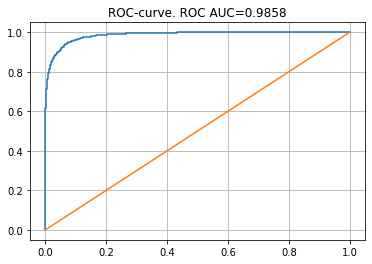

Остальные метрики:
     accuracy: 0.934
     precision: 0.941
     recall: 0.928
     f1-score: 0.934


In [112]:
params = {'objective': 'binary',
          'num_leaves': 50,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.9,
          'learning_rate':0.1,          
          'lambda_l2': 100,
          'metric':'auc',          
          }
    
    # обучение модели
num_trees = 1000
lgbm = lgb.train(params.copy(),dtrain,num_boost_round = num_trees,valid_sets=[dtrain,dvalid],
                      #evals_result=evals_result
                      #,early_stopping_rounds=20
                      verbose_eval = 100)

print('Обучился!')

y_pred_bst = lgbm.predict(X_test)
print_metrics(y_pred_bst,y_test)